In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from torch.autograd import Variable

import time
import io
import os
import pickle
import argparse
from PIL import Image
import numpy as np

from Vocabulary import load_captions
from Vocabulary import Vocabulary
from DataLoader import DataLoader, shuffle_data
from Dutch_Translation import *
%matplotlib inline

# Encoder CNN with pretrained VGG16

In [9]:
class EncoderCNN(nn.Module):
    # Pretrained network download and replacing the final layer
    def __init__(self, embed_dim):
        """Load the pretrained vgg16 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        in_features = self.vgg16.classifier[6].in_features
        self.linear = nn.Linear(in_features, embed_dim)
        self.vgg16.classifier[6] = self.linear
        self.init_weights()
        
    def init_weights(self):
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)
    #forward pass
    def forward(self, images):
        embed = self.vgg16(images)
        return embed

# Decoder RNN with LSTM Module

In [10]:
class DecoderRNN(nn.Module):
    # Defining the RNN with word embeddings and lstm
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(DecoderRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        self.word_embeddings.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
     
    # Forward pass with embeddings and lstm
    def forward(self, features, caption):
        seq_length = len(caption) + 1
        embeds = self.word_embeddings(caption)
        embeds = torch.cat((features, embeds), 0)
        lstm_out, _ = self.lstm(embeds.unsqueeze(1))
        out = self.linear(lstm_out.view(seq_length, -1))
        return out
  
    #Generating the captions 
    def greedy(self, cnn_out, seq_len = 20):
        ip = cnn_out
        hidden = None
        ids_list = []
        for t in range(seq_len):
            lstm_out, hidden = self.lstm(ip.unsqueeze(1), hidden)
            # generating single word at a time
            linear_out = self.linear(lstm_out.squeeze(1))
            word_caption = linear_out.max(dim=1)[1]
            ids_list.append(word_caption)
            ip = self.word_embeddings(word_caption)
        return ids_list

## Training with adam optimizer and learning rate of 1e-3

In [11]:
def main():
    train_dir = "/home/team8/Project/train"
    threshold = 5
    captions_dict = load_captions(train_dir)
    vocab = Vocabulary(captions_dict, threshold)
    with open('vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f)

    transform = transforms.Compose([transforms.Resize((224, 224)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

    dataloader = DataLoader(train_dir, vocab, transform)
    data = dataloader.gen_data()
    
    # Defining the models 
    vocab_size = vocab.index
    hidden_dim = 512
    embedding_dim = 300
    learning_rate = 1e-3
    cnn = EncoderCNN(embedding_dim)
    lstm = DecoderRNN(embedding_dim,hidden_dim,vocab_size = vocab_size)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.to(device)
    lstm.to(device)
    
    #Loss functions with adam optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(cnn.linear.parameters()) + list(lstm.parameters()) 
    optimizer = torch.optim.Adam(params, lr = learning_rate)
    num_epochs = 25
    
    #training loop
    for epoch in range(num_epochs):
        shuffled_images, shuffled_captions = shuffle_data(data, seed = epoch)
        num_captions = len(shuffled_captions)
        loss_list = []
        tic = time.time()
        for i in range(num_captions):
            image_id = shuffled_images[i]
            image = dataloader.get_image(image_id)
            image = image.unsqueeze(0)

            image = Variable(image).cuda()
            caption = torch.cuda.LongTensor(shuffled_captions[i])
            caption_train = caption[:-1] # remove <end>
            cnn.zero_grad()
            lstm.zero_grad()

            cnn_out = cnn(image)
            lstm_out = lstm(cnn_out, caption_train)
            loss = criterion(lstm_out, caption)
            loss.backward()
            optimizer.step()
            loss_list.append(loss)
        toc = time.time()
        avg_loss = torch.mean(torch.Tensor(loss_list))
        print('epoch %d avg_loss %f time %.2f mins' %(epoch, avg_loss, (toc-tic)/60))
        if (epoch+1 % 10 == 0) or (epoch+1==25):
            torch.save(cnn.state_dict(),'iter_%d_cnn.pkl'%(epoch))
            torch.save(lstm.state_dict(),'iter_%d_lstm.pkl'%(epoch))

## Test module to predict for new images

In [22]:
def test(file):
    train_dir = "/home/team8/Project/train"
    threshold = 5
    captions_dict = load_captions(train_dir)
    vocab = Vocabulary(captions_dict, threshold)
    vocab_size = vocab.index
    hidden_dim = 512
    embedding_dim = 300
    learning_rate = 1e-3
    cnn = EncoderCNN(embedding_dim)
    lstm = DecoderRNN(embedding_dim,hidden_dim,vocab_size = vocab_size)
    transform = transforms.Compose([transforms.Resize((224, 224)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.to(device)
    lstm.to(device)
    
    #### Prediction for test images
    cnn.load_state_dict(torch.load("/home/team8/iter_24_cnn.pkl"))
    lstm.load_state_dict(torch.load("/home/team8/iter_24_lstm.pkl"))
    pil_im = Image.open(file, 'r')#
    pil_im1 = transform(pil_im)
    pil_im1 = pil_im1.unsqueeze(0)
    pil_im1 = Variable(pil_im1).cuda()
    cnn_out = cnn(pil_im1)
    lstm_out = lstm.greedy(cnn_out)
    imshow(np.asarray(pil_im))
    pred = vocab.get_sentence(lstm_out)
    pred = pred.replace("<start>","").replace("<end>","").strip()
    print("English Caption: ",pred)
    print("Dutch Caption: ",translation(pred)[1])

English Caption:  a man is climbing a rock .
Dutch Caption:  een is is een . <EOS>


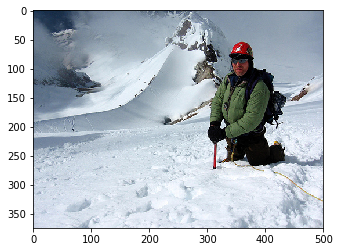

In [23]:
test("/home/team8/Project/test/485245061_5a5de43e20.jpg")